In [ ]:
## DeepExplain - Keras (TF backend) example
### MNIST with CNN

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tempfile, sys, os
sys.path.insert(0, os.path.abspath('..'))

import keras
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

# Import DeepExplain
from deepexplain.tensorflow import DeepExplain

In [3]:
# Build and train a network.

batch_size = 128
num_classes = 10
epochs = 1

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
x_train = (x_train - 0.5) * 2
x_test = (x_test - 0.5) * 2
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax')) 
# ^ IMPORTANT: notice that the final softmax must be in its own layer 
# if we want to target pre-softmax units

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 9s 152us/step - loss: 0.2310 - acc: 0.9288 - val_loss: 0.0499 - val_acc: 0.9839
Test loss: 0.049899946462642404
Test accuracy: 0.9839


In [3]:
with DeepExplain(session=K.get_session()) as de:  # <-- init DeepExplain context
    # Need to reconstruct the graph in DeepExplain context, using the same weights.
    # With Keras this is very easy:
    # 1. Get the input tensor to the original model
    input_tensor = model.layers[0].input
    
    # 2. We now target the output of the last dense layer (pre-softmax)
    # To do so, create a new model sharing the same layers untill the last dense (index -2)
    fModel = Model(inputs=input_tensor, outputs = model.layers[-2].output)
    target_tensor = fModel(input_tensor)
    
    xs = x_test[0:10]
    ys = y_test[0:10]
    
    attributions_gradin = de.explain('grad*input', target_tensor * ys, input_tensor, xs)
    #attributions_sal   = de.explain('saliency', target_tensor * ys, input_tensor, xs)
    #attributions_ig    = de.explain('intgrad', target_tensor * ys, input_tensor, xs)
    #attributions_dl    = de.explain('deeplift', target_tensor * ys, input_tensor, xs)
    #attributions_elrp  = de.explain('elrp', target_tensor * ys, input_tensor, xs)
    #attributions_occ   = de.explain('occlusion', target_tensor * ys, input_tensor, xs)
    
    # Compare Gradient * Input with approximate Shapley Values
    # Note1: Shapley Value sampling with 100 samples per feature (78400 runs) takes a couple of minutes on a GPU.
    # Note2: 100 samples are not enough for convergence, the result might be affected by sampling variance
    attributions_sv     = de.explain('shapley_sampling', target_tensor * ys, input_tensor, xs, samples=100)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


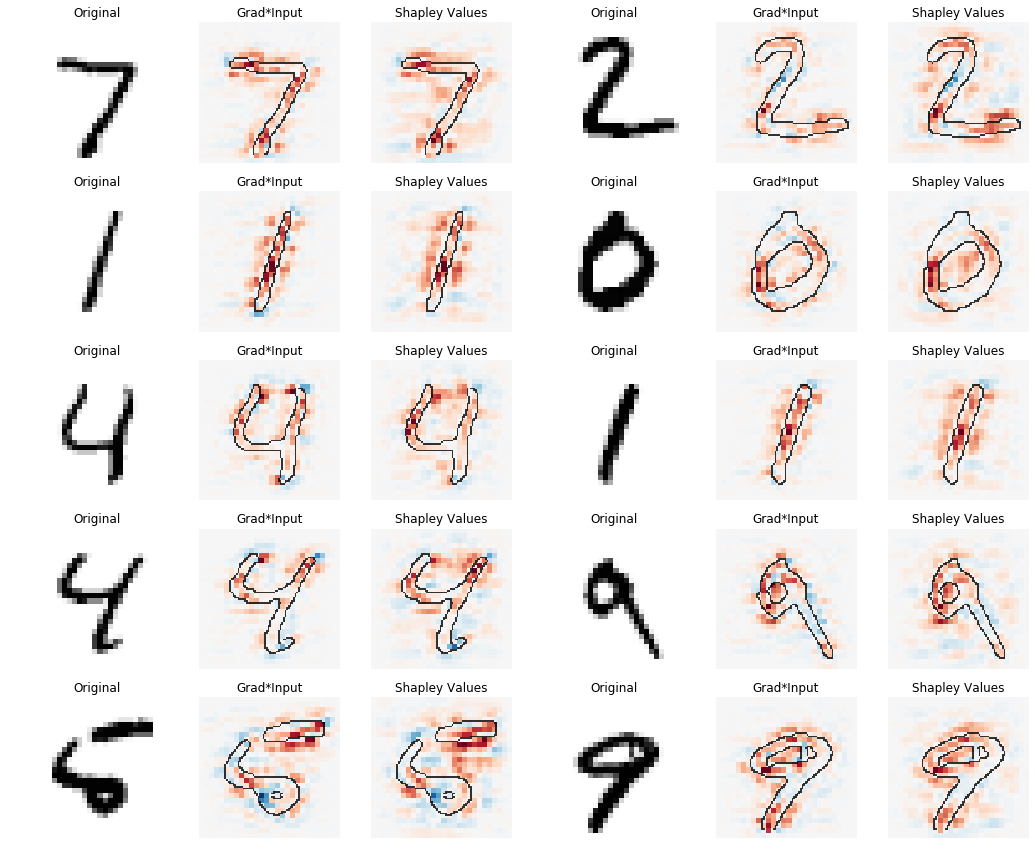

In [5]:
# Plot attributions
from utils import plot, plt
%matplotlib inline

n_cols = 6
n_rows = int(len(attributions_gradin) / 2)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(3*n_cols, 3*n_rows))

for i, (a1, a2) in enumerate(zip(attributions_gradin, attributions_sv)):
    row, col = divmod(i, 2)
    plot(xs[i].reshape(28, 28), cmap='Greys', axis=axes[row, col*3]).set_title('Original')
    plot(a1.reshape(28,28), xi = xs[i], axis=axes[row,col*3+1]).set_title('Grad*Input')
    plot(a2.reshape(28,28), xi = xs[i], axis=axes[row,col*3+2]).set_title('Shapley Values')

## Batch processing
In this example, we generate explanations for the entire testset (10000 images) using the fast Gradient*Input method.
`DeepExplain.explain()` accepts the `batch_size` parameter if the data to process does not fit in memory.

In [4]:
with DeepExplain(session=K.get_session()) as de:  # <-- init DeepExplain context
    # Need to reconstruct the graph in DeepExplain context, using the same weights.
    # With Keras this is very easy:
    # 1. Get the input tensor to the original model
    input_tensor = model.layers[0].input
    
    # 2. We now target the output of the last dense layer (pre-softmax)
    # To do so, create a new model sharing the same layers untill the last dense (index -2)
    fModel = Model(inputs=input_tensor, outputs = model.layers[-2].output)
    target_tensor = fModel(input_tensor)
    
    xs = x_test
    ys = y_test
    
    
    attributions_gradin = de.explain('grad*input', target_tensor * ys, input_tensor, xs, batch_size=128)
    print ("Done")

InvalidArgumentError: Incompatible shapes: [128,10] vs. [10000,10]
	 [[node gradients/mul_grad/BroadcastGradientArgs (defined at /home/anconam/projects/DeepExplain/deepexplain/tensorflow/methods.py:231)  = BroadcastGradientArgs[T=DT_INT32, _device="/job:localhost/replica:0/task:0/device:GPU:0"](gradients/mul_grad/Shape, gradients/mul_grad/Shape_1)]]
	 [[{{node mul_1/_123}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_267_mul_1", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'gradients/mul_grad/BroadcastGradientArgs', defined at:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.6/dist-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 427, in run_forever
    self._run_once()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 1440, in _run_once
    handle._run()
  File "/usr/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/usr/local/lib/python3.6/dist-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/usr/local/lib/python3.6/dist-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/usr/local/lib/python3.6/dist-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py", line 370, in dispatch_queue
    yield self.process_one()
  File "/usr/local/lib/python3.6/dist-packages/tornado/gen.py", line 346, in wrapper
    runner = Runner(result, future, yielded)
  File "/usr/local/lib/python3.6/dist-packages/tornado/gen.py", line 1080, in __init__
    self.run()
  File "/usr/local/lib/python3.6/dist-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/usr/local/lib/python3.6/dist-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/usr/local/lib/python3.6/dist-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/usr/local/lib/python3.6/dist-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 3185, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-8dc8d53dafd6>", line 16, in <module>
    attributions_gradin = de.explain('grad*input', target_tensor * ys, input_tensor, xs, batch_size=128)
  File "/home/anconam/projects/DeepExplain/deepexplain/tensorflow/methods.py", line 566, in explain
    result = method.run()
  File "/home/anconam/projects/DeepExplain/deepexplain/tensorflow/methods.py", line 164, in run
    symbolic_attribution = self.get_symbolic_attribution()
  File "/home/anconam/projects/DeepExplain/deepexplain/tensorflow/methods.py", line 231, in get_symbolic_attribution
    tf.gradients(self.T, self.X),
  File "/home/anconam/.local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py", line 630, in gradients
    gate_gradients, aggregation_method, stop_gradients)
  File "/home/anconam/.local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py", line 814, in _GradientsHelper
    lambda: grad_fn(op, *out_grads))
  File "/home/anconam/.local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py", line 408, in _MaybeCompile
    return grad_fn()  # Exit early
  File "/home/anconam/.local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py", line 814, in <lambda>
    lambda: grad_fn(op, *out_grads))
  File "/home/anconam/.local/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py", line 940, in _MulGrad
    rx, ry = gen_array_ops.broadcast_gradient_args(sx, sy)
  File "/home/anconam/.local/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 676, in broadcast_gradient_args
    "BroadcastGradientArgs", s0=s0, s1=s1, name=name)
  File "/home/anconam/.local/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/anconam/.local/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/home/anconam/.local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3274, in create_op
    op_def=op_def)
  File "/home/anconam/.local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

...which was originally created as op 'mul', defined at:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
[elided 30 identical lines from previous traceback]
  File "<ipython-input-4-8dc8d53dafd6>", line 16, in <module>
    attributions_gradin = de.explain('grad*input', target_tensor * ys, input_tensor, xs, batch_size=128)
  File "/home/anconam/.local/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py", line 878, in binary_op_wrapper
    return func(x, y, name=name)
  File "/home/anconam/.local/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py", line 1131, in _mul_dispatch
    return gen_math_ops.mul(x, y, name=name)
  File "/home/anconam/.local/lib/python3.6/site-packages/tensorflow/python/ops/gen_math_ops.py", line 5042, in mul
    "Mul", x=x, y=y, name=name)
  File "/home/anconam/.local/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/anconam/.local/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/home/anconam/.local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3274, in create_op
    op_def=op_def)
  File "/home/anconam/.local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): Incompatible shapes: [128,10] vs. [10000,10]
	 [[node gradients/mul_grad/BroadcastGradientArgs (defined at /home/anconam/projects/DeepExplain/deepexplain/tensorflow/methods.py:231)  = BroadcastGradientArgs[T=DT_INT32, _device="/job:localhost/replica:0/task:0/device:GPU:0"](gradients/mul_grad/Shape, gradients/mul_grad/Shape_1)]]
	 [[{{node mul_1/_123}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_267_mul_1", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
